## Импорт модулей

### Импорт модулей не PySpark

In [1]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import seaborn as sns 
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

### Импорт модулей PySpark

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.ml.stat import Correlation
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, count, when
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

## Анализ данных

### Инициализация сессии Spark

In [3]:
MAX_MEMORY = '15G'
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

### Загрузка данных

In [4]:
filename_data = 'data/daily_dataset.csv'
df = spark.read.option("inferSchema",True) \
                .option("delimiter",",") \
                .option("header", True) \
  .csv(filename_data)

### Вывод колонок и их типов

In [5]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- LCLid: string (nullable = true)
 |-- day: timestamp (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)

Columns overview


,Column Name,Data type
0,LCLid,string
1,day,timestamp
2,energy_median,double
3,energy_mean,double
4,energy_max,double
5,energy_count,int
6,energy_std,double
7,energy_sum,double
8,energy_min,double


## Подсчет пропущенных значений в дата фрейме

In [6]:
# Функция подсчета пропущенных значений
def CountMissingValues(df):
    df.select(*[
        (
            F.count(F.when((F.isnan(c)) | (F.col(c).isNull()) | (F.col(c)=='None') | (F.col(c)=='NULL') | (F.col(c)==''), c)) if t not in ("timestamp", "date")
            else F.count(F.when((F.col(c).isNull()) | (F.col(c)=='None') | (F.col(c)=='NULL') | (F.col(c)==''), c))
        ).alias(c)
        for c, t in df.dtypes if c in df.columns
    ]).show()

## Очистка датафрейма

In [23]:
# Очистка пропущенных значений
print("Количество пропущенных значений до удаления")
CountMissingValues(df)
df_WN = df.na.drop("any")
print("Количество пропущенных значений после удаления")
CountMissingValues(df_WN)

Количество пропущенных значений до удаления
+-----+---+-------------+-----------+----------+------------+----------+----------+----------+
|LCLid|day|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-----+---+-------------+-----------+----------+------------+----------+----------+----------+
|    0|  0|           30|         30|        30|           0|     11331|        30|        30|
+-----+---+-------------+-----------+----------+------------+----------+----------+----------+

Количество пропущенных значений после удаления
+-----+---+-------------+-----------+----------+------------+----------+----------+----------+
|LCLid|day|energy_median|energy_mean|energy_max|energy_count|energy_std|energy_sum|energy_min|
+-----+---+-------------+-----------+----------+------------+----------+----------+----------+
|    0|  0|            0|          0|         0|           0|         0|         0|         0|
+-----+---+-------------+-----------+----------+-----

In [26]:
# Удаление ненужных столбцов
df.printSchema()
df_WN = df_WN.drop("day", "LCLid")
df_WN.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- day: timestamp (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)

root
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)



In [9]:
# функция вывода графиков с выбросами
def digrams_of_outliers(df):
    for c in df.columns: 
        column_df = df.select(c).toPandas()
        sns.boxplot(column_df)
        plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


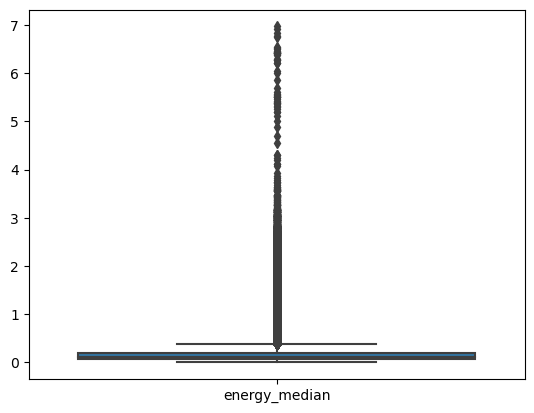

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


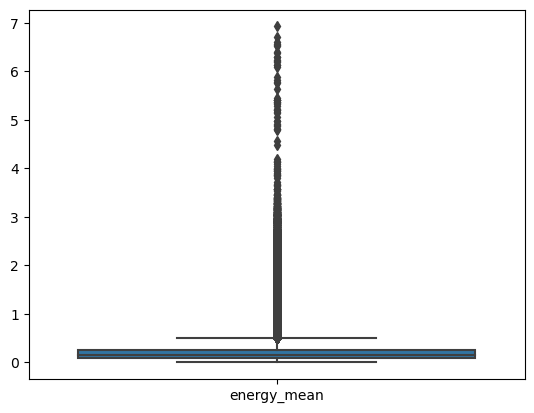

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


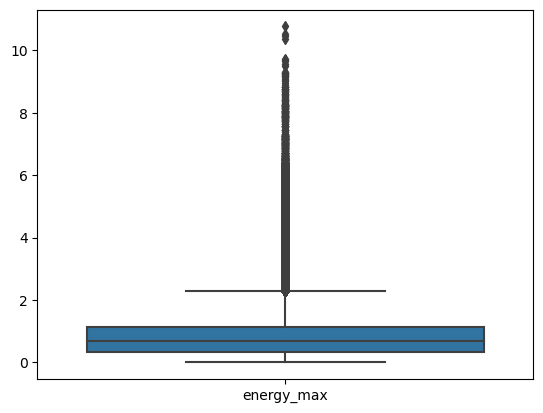

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


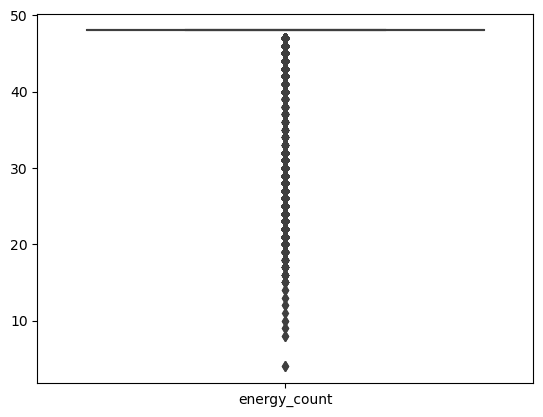

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


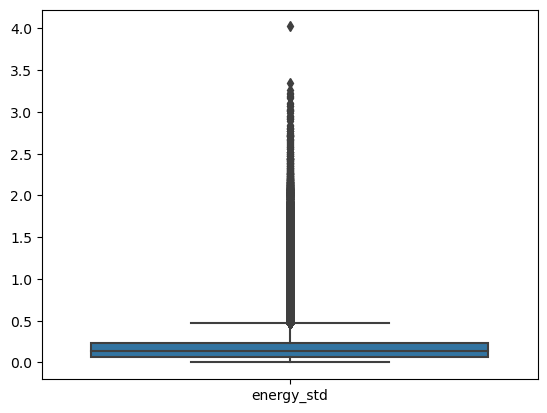

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


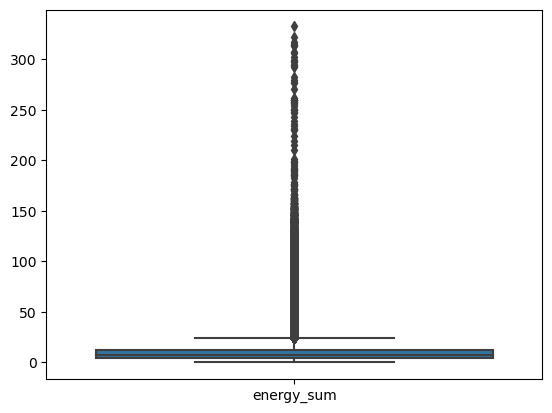

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


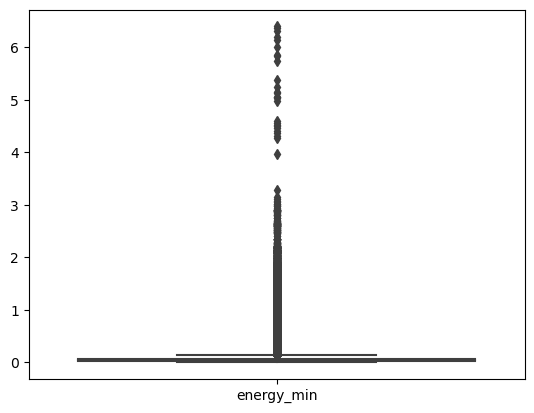

In [10]:
digrams_of_outliers(df_WN)

In [11]:
# Функция получения границ
def get_bounds(df):
    bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0.01))
    )
    for c in df.columns
    }

    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
    return bounds

# Функция подсчета количества выбросов
def number_of_outliers(df, bounds):
    outliers_table_df = df.select(
    [
        F.when(
            F.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in df.columns
    ])

    number_of_outliers_df = outliers_table_df.select([
                        (
                            F.count(F.when((F.col(c)=='1'), c))
                        ).alias(c)
                        for c in outliers_table_df.columns
                        ])
    number_of_outliers_df.show()

In [12]:
# Удаление и показ количества выбросов
numeric_df = df_WN
for t in df_WN.dtypes:
        if t[1] == 'string' or t[1] == 'timestamp': 
            numeric_df = numeric_df.drop(t[0])

bounds = get_bounds(numeric_df)
number_of_outliers(numeric_df, bounds)

df_2 = numeric_df.select(
     *[
        F.when(
             F.col(c).between(bounds[c]['lower'], bounds[c]['upper']), F.col(c)
         ).otherwise(None).alias(c) 
        for c in numeric_df.columns
     ]
 )

df_2 = df_2.dropna()
number_of_outliers(df_2, bounds)

+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|energy_median_out|energy_mean_out|energy_max_out|energy_count_out|energy_std_out|energy_sum_out|energy_min_out|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|           228286|         201106|        125877|           29750|        164196|        206561|        227676|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+

+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|energy_median_out|energy_mean_out|energy_max_out|energy_count_out|energy_std_out|energy_sum_out|energy_min_out|
+-----------------+---------------+--------------+----------------+--------------+--------------+--------------+
|                0|              0|             0|               0|             0|             

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


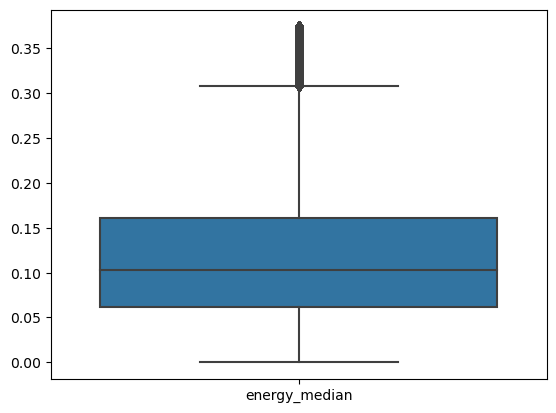

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


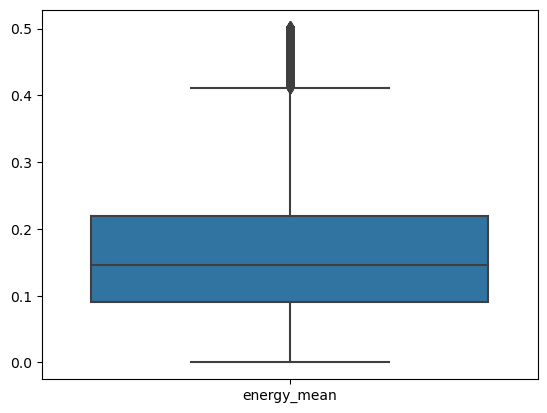

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


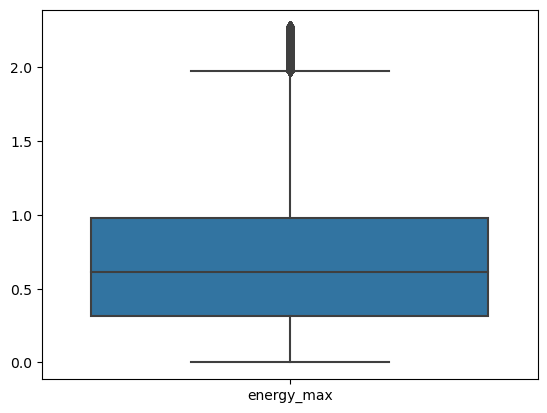

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


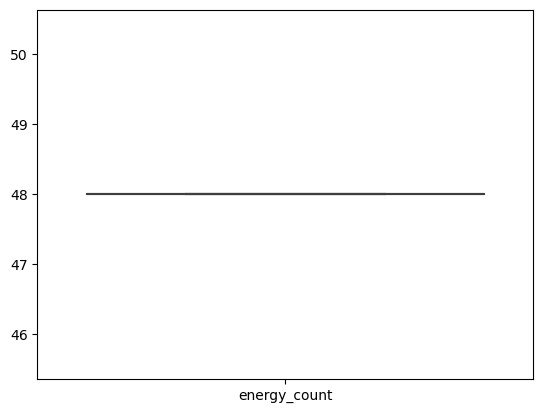

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


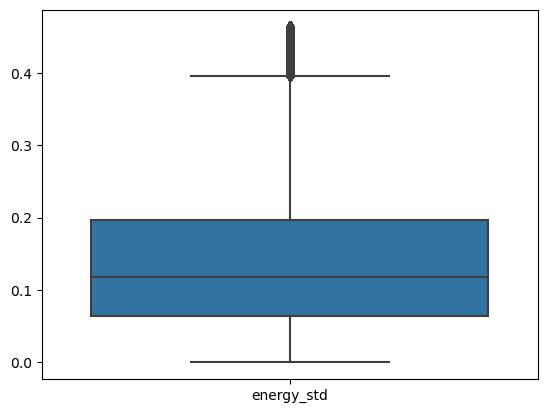

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


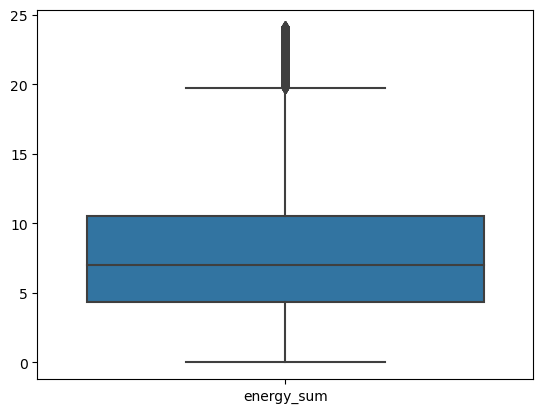

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


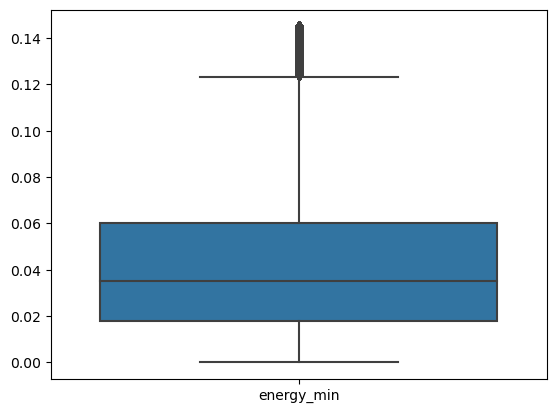

In [19]:
digrams_of_outliers(df_2)

### Расчет статистических показателей

In [14]:
removed_df = df_2.toPandas().describe().astype(float)
removed_df.T

,count,mean,std,min,25%,50%,75%,max
energy_median,3042616.0,0.118319,0.074065,0.0,0.062000,0.102500,0.160500,0.374500
energy_mean,3042616.0,0.162498,0.093654,0.0,0.090792,0.146083,0.219208,0.503229
energy_max,3042616.0,0.692577,0.462645,0.0,0.316000,0.610000,0.980000,2.277000
energy_count,3042616.0,48.000000,0.000000,48.0,48.000000,48.000000,48.000000,48.000000
energy_std,3042616.0,0.139730,0.097191,0.0,0.063433,0.118410,0.196322,0.463973
energy_sum,3042616.0,7.799899,4.495386,0.0,4.358000,7.012000,10.522000,24.155000
energy_min,3042616.0,0.042689,0.031929,0.0,0.018000,0.035000,0.060000,0.145000


### Подсчет корреляций и вывод корелляционной матрицы

In [15]:
# Перевести столбцы в векторный вид
assembler = VectorAssembler(
    inputCols=df_2.columns,
    outputCol="features")
print('До перевода в векторный вид:')
df_2.show()
print('После перевода в векторный вид:')
output = assembler.transform(df_2)
output.select("features").show(truncate=False)

# ПОСТРОЕНИЕ МАТРИЦЫ КОРРЕЛЯЦИИ МЕЖДУ ПРИЗНАКАМИ
# Построение самой матрицы
matrix = Correlation.corr(output, "features").collect()[0][0]

# Перевод матрицы в лист, для дальнейшего правильного отображения
corrmatrix = matrix.toArray().tolist()

# Копия колонок из исходного датасета, для формирования матрицы корреляции
columns = df_2.columns

# Формированиt матрицы корреляции
df_corr = spark.createDataFrame(corrmatrix, columns)

df_pd = df_corr.toPandas()
df_pd.index = df_corr.columns
df_pd

До перевода в векторный вид:
+-------------------+-------------------+------------------+------------+-------------------+------------------+----------+
|      energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|energy_min|
+-------------------+-------------------+------------------+------------+-------------------+------------------+----------+
|             0.1415|0.29616666875000003|         1.1160001|          48| 0.2814713178628203|14.216000100000002|     0.031|
|             0.1015|          0.1898125|             0.685|          48| 0.1884046862418033|             9.111|     0.064|
|              0.114| 0.2189791666666666|0.6759999999999999|          48|0.20291927853038208|10.510999999999996|     0.065|
|              0.191|0.32597916666666665|0.7879999999999999|          48| 0.2592049619947409|15.646999999999998|     0.066|
|0.21800000000000005|             0.3575|             1.077|          48|0.28759657027517305|          

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
energy_median,1.000000,0.886252,0.493438,NaN,0.514547,0.886252,0.682119
energy_mean,0.886252,1.000000,0.746958,NaN,0.814137,1.000000,0.621188
energy_max,0.493438,0.746958,1.000000,NaN,0.945440,0.746958,0.284913
energy_count,NaN,NaN,NaN,1.0,NaN,NaN,NaN
energy_std,0.514547,0.814137,0.945440,NaN,1.000000,0.814137,0.243589
energy_sum,0.886252,1.000000,0.746958,NaN,0.814137,1.000000,0.621188
energy_min,0.682119,0.621188,0.284913,NaN,0.243589,0.621188,1.000000


In [16]:
New_df = df_2.sample(True, 0.001, seed=1234)
New_df = New_df.toPandas()

In [17]:
# Вывод матрицы корреляции для преобразованного датафрейма
corrM = New_df.corr()
corrM

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
energy_median,1.000000,0.889477,0.495739,NaN,0.514701,0.889477,0.671720
energy_mean,0.889477,1.000000,0.748211,NaN,0.809783,1.000000,0.609583
energy_max,0.495739,0.748211,1.000000,NaN,0.948220,0.748211,0.259083
energy_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_std,0.514701,0.809783,0.948220,NaN,1.000000,0.809783,0.215683
energy_sum,0.889477,1.000000,0.748211,NaN,0.809783,1.000000,0.609583
energy_min,0.671720,0.609583,0.259083,NaN,0.215683,0.609583,1.000000


array([[<AxesSubplot: title={'center': 'energy_median'}>,
        <AxesSubplot: title={'center': 'energy_mean'}>,
        <AxesSubplot: title={'center': 'energy_max'}>],
       [<AxesSubplot: title={'center': 'energy_count'}>,
        <AxesSubplot: title={'center': 'energy_std'}>,
        <AxesSubplot: title={'center': 'energy_sum'}>],
       [<AxesSubplot: title={'center': 'energy_min'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

<AxesSubplot: >

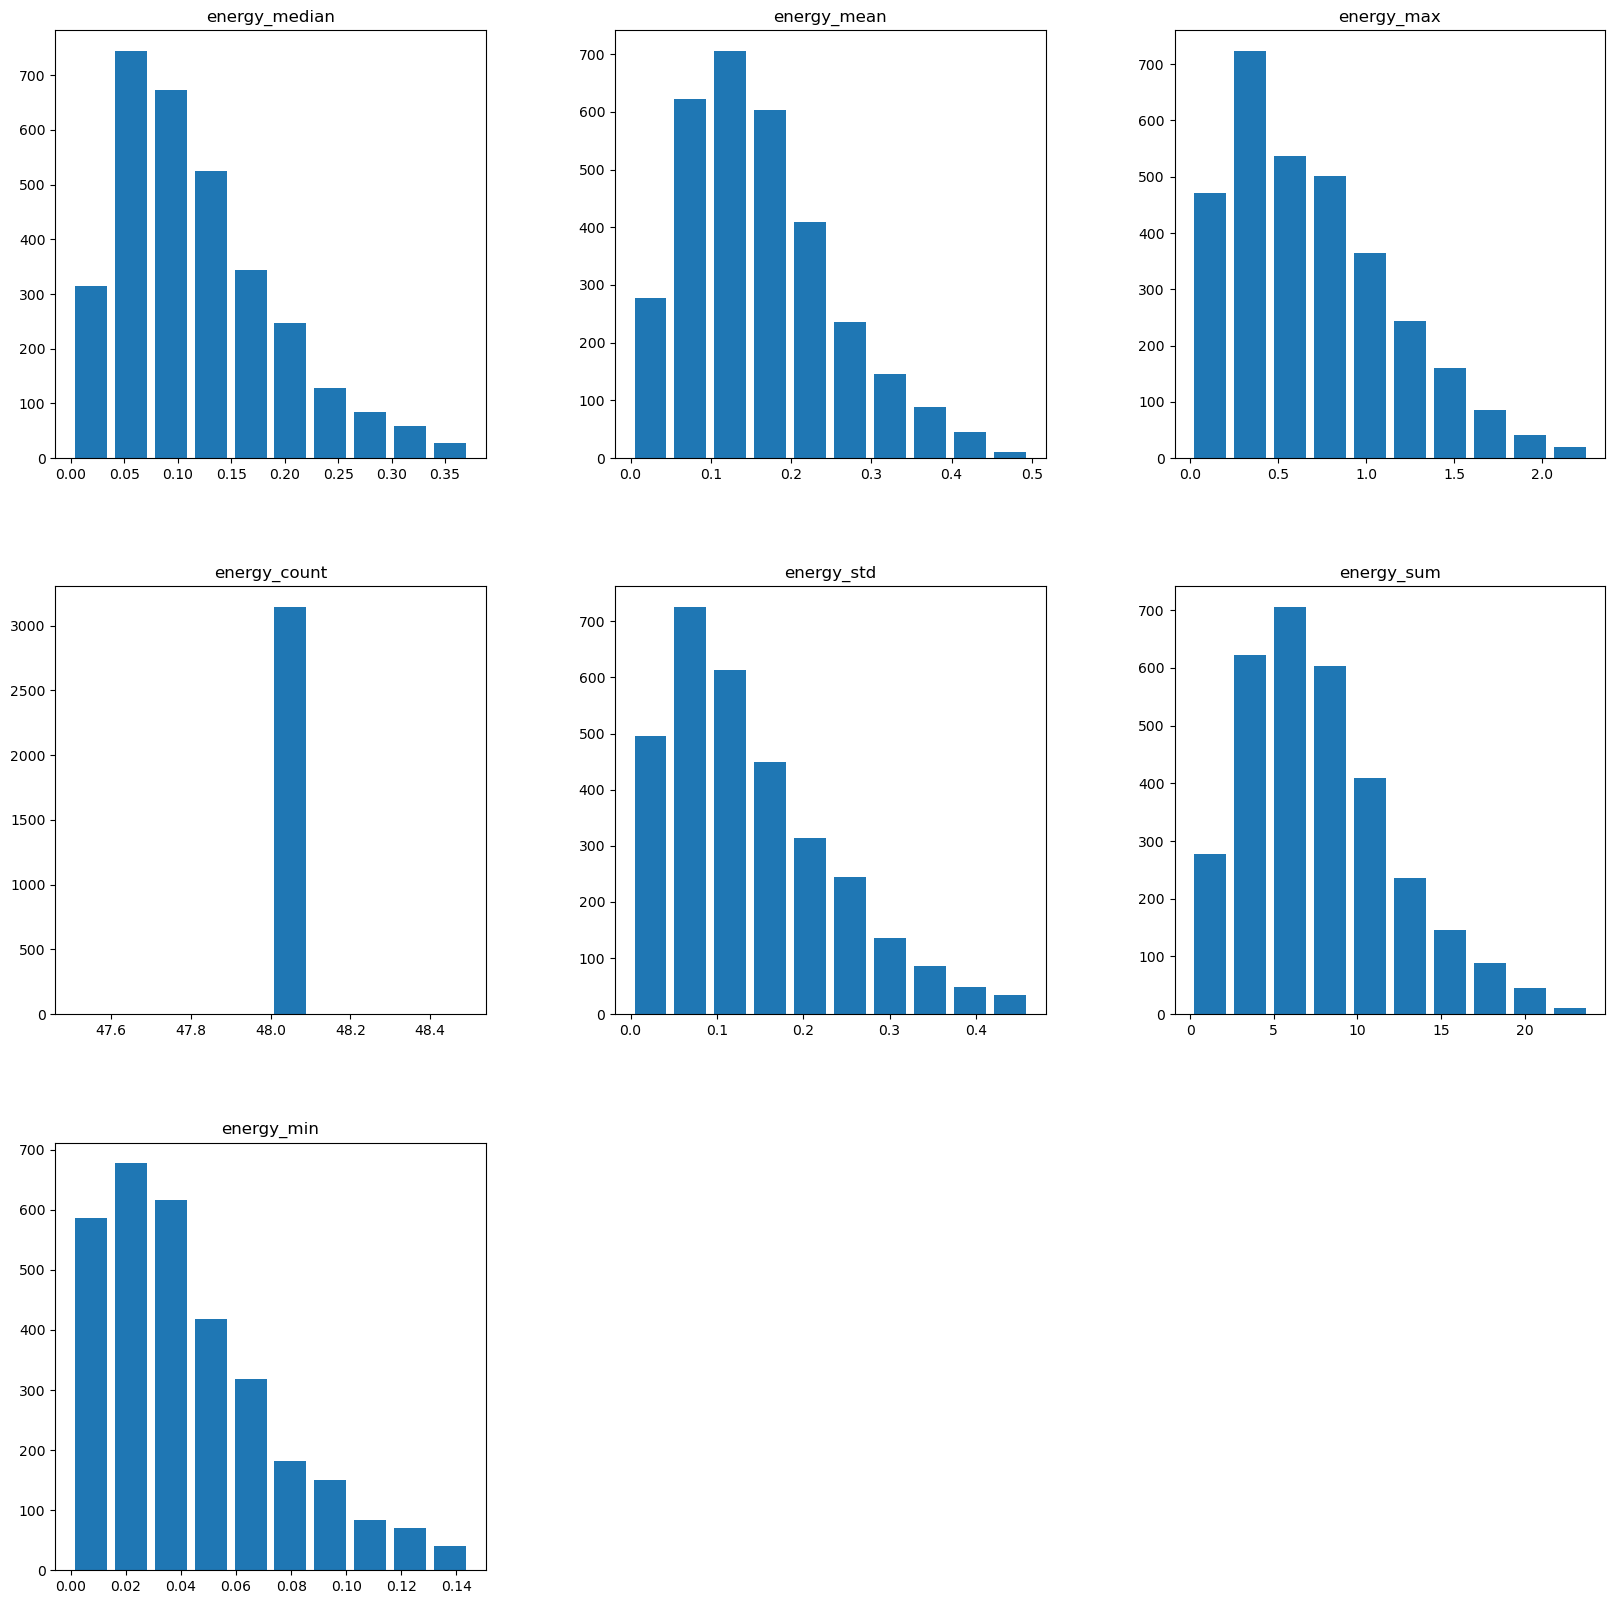

In [18]:
# Построение графиков распределения признаков
New_df.hist(figsize = (20,20), grid = False, rwidth = 0.8)
New_df.boxplot(figsize = (20,20), grid = False)